In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, silhouette_score

In [2]:
data = pd.read_csv('data/cc_general.csv')
data.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [3]:
data.drop('CUST_ID', axis=1, inplace=True)

In [4]:
data.dropna(inplace=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8636 entries, 0 to 8949
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8636 non-null   float64
 1   BALANCE_FREQUENCY                 8636 non-null   float64
 2   PURCHASES                         8636 non-null   float64
 3   ONEOFF_PURCHASES                  8636 non-null   float64
 4   INSTALLMENTS_PURCHASES            8636 non-null   float64
 5   CASH_ADVANCE                      8636 non-null   float64
 6   PURCHASES_FREQUENCY               8636 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8636 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8636 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8636 non-null   float64
 10  CASH_ADVANCE_TRX                  8636 non-null   int64  
 11  PURCHASES_TRX                     8636 non-null   int64  
 12  CREDIT

In [6]:
# Find closely correlated features and remove them
num_corr = data.corr()
features = list(num_corr.columns)
print('original feature length: {}'.format(len(features)))

# Loops to check correlation under diagonal (where columns correlate with themselves)
for x in range(0, len(num_corr.columns), 1):
    col =  abs(num_corr.iloc[(x+1):, x]).sort_values(ascending=False)
    for y in range(len(col)):
        if col[y] > .75:
            if col.index[y] in features:
                features.remove(col.index[y])
print('new feature length: {}'.format(len(features)))

original feature length: 17
new feature length: 14


In [7]:
# replace data with updatad features list
data = data[features]
data.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,CASH_ADVANCE_FREQUENCY,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,95.40,0.000000,0.166667,0.000000,0.00,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,6442.945483,0.000000,0.000000,0.25,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,0.00,0.000000,1.000000,1.000000,0.00,12,7500.0,622.066742,627.284787,0.000000,12
4,817.714335,1.000000,16.00,0.00,0.000000,0.083333,0.083333,0.00,1,1200.0,678.334763,244.791237,0.000000,12
5,1809.828751,1.000000,1333.28,1333.28,0.000000,0.666667,0.000000,0.00,8,1800.0,1400.057770,2407.246035,0.000000,12


In [8]:
# Treat numeric columns with less than 10 unique values as categorical features and transform into dummy variables
for col in data.columns:    
    if len(data[col].unique()) < 10:
        dum = pd.get_dummies(data[col], prefix=col, drop_first=True)
        data.drop(col, axis=1, inplace=True)

,BALANCE,BALANCE_FREQUENCY,PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,CASH_ADVANCE_FREQUENCY,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE_7,TENURE_8,TENURE_9,TENURE_10,TENURE_11,TENURE_12
0,40.900749,0.818182,95.40,95.40,0.000000,0.166667,0.000000,0.00,2,1000.0,201.802084,139.509787,0.000000,0,0,0,0,0,1
1,3202.467416,0.909091,0.00,0.00,6442.945483,0.000000,0.000000,0.25,0,7000.0,4103.032597,1072.340217,0.222222,0,0,0,0,0,1
2,2495.148862,1.000000,773.17,0.00,0.000000,1.000000,1.000000,0.00,12,7500.0,622.066742,627.284787,0.000000,0,0,0,0,0,1
4,817.714335,1.000000,16.00,0.00,0.000000,0.083333,0.083333,0.00,1,1200.0,678.334763,244.791237,0.000000,0,0,0,0,0,1
5,1809.828751,1.000000,1333.28,1333.28,0.000000,0.666667,0.000000,0.00,8,1800.0,1400.057770,2407.246035,0.000000,0,0,0,0,0,1


In [9]:
# Scale data
scale = StandardScaler()
scaled = scale.fit_transform(df)

In [16]:
pd.DataFrame(scaled)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-0.744625,-0.370047,-0.429184,-0.354826,-0.468655,-0.820769,-0.686280,-0.681953,-0.517623,-0.962575,-0.543942,-0.305508,-0.537727,-0.144653,-0.147136,-0.139133,-0.163929,-0.207353,0.419053
1,0.764152,0.067679,-0.473208,-0.458839,2.568556,-1.236139,-0.686280,0.557022,-0.597054,0.677204,0.796852,0.087689,0.212380,-0.144653,-0.147136,-0.139133,-0.163929,-0.207353,0.419053
2,0.426602,0.505405,-0.116413,-0.458839,-0.468655,1.256077,2.646651,-0.681953,-0.120467,0.813852,-0.399503,-0.099906,-0.537727,-0.144653,-0.147136,-0.139133,-0.163929,-0.207353,0.419053
3,-0.373910,0.505405,-0.465825,-0.458839,-0.468655,-1.028455,-0.408536,-0.681953,-0.557339,-0.907916,-0.380165,-0.261131,-0.537727,-0.144653,-0.147136,-0.139133,-0.163929,-0.207353,0.419053
4,0.099551,0.505405,0.142062,0.994815,-0.468655,0.425339,-0.686280,-0.681953,-0.279329,-0.743938,-0.132119,0.650363,-0.537727,-0.144653,-0.147136,-0.139133,-0.163929,-0.207353,0.419053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8631,-0.761342,-1.902089,-0.463563,-0.458839,-0.468655,-0.820769,-0.130790,-0.681953,-0.557339,-1.099224,-0.593143,-0.345988,-0.537727,-0.144653,-0.147136,-0.139133,-0.163929,-0.207353,-2.386331
8632,-0.750546,0.505405,-0.338865,-0.141436,-0.468655,1.256077,-0.686280,-0.681953,-0.358760,-0.962575,-0.501396,-0.343706,1.150015,-0.144653,-0.147136,-0.139133,-0.163929,-0.207353,-2.386331
8633,-0.752977,-0.297095,-0.406572,-0.301402,-0.468655,0.840707,-0.686280,-0.681953,-0.398476,-0.962575,-0.585367,-0.329572,0.306144,-0.144653,-0.147136,-0.139133,-0.163929,-0.207353,-2.386331
8634,-0.757721,-0.297095,-0.473208,-0.458839,-0.451422,-1.236139,-0.686280,0.144032,-0.597054,-1.099224,-0.595238,-0.340811,0.306144,-0.144653,-0.147136,-0.139133,-0.163929,-0.207353,-2.386331


In [10]:
# Use DBSCAN for init exploratory clustering

# Function will rank best clustering parameters using adjusted_rand_score as the scoring metric
def best_dbscan_cluster(scaled):
    
    # Initialize values
    range_list = np.arange(1, 8, 1)
    best = 0
    score = {}
    
    # Loop through hyperparameters and save best scoring combinations
    for eps in range_list:
        
        for min_samp in range_list:
            dbscan = DBSCAN(eps=eps, min_samples=min_samp, n_jobs=8)
            clusters = dbscan.fit_predict(scaled)
            sil_score = silhouette_score(scaled, clusters, metric='euclidean')
                
            if sil_score > best:
                best = sil_score
                score['eps'] = eps
                score['min_samps'] = min_samp
                score['silhouette_score'] = sil_score
                score['clusters'] = len(np.unique(clusters))
                
    return score

In [11]:
# Run function with scaled data. Display the dictionary of results for initial idea of cluster amount
score = best_dbscan_cluster(scaled)
score

{'eps': 6,
 'min_samps': 3,
 'silhouette_score': 0.4544023817402984,
 'clusters': 6}

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 8636 samples in 0.040s...
[t-SNE] Computed neighbors for 8636 samples in 1.078s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8636
[t-SNE] Computed conditional probabilities for sample 2000 / 8636
[t-SNE] Computed conditional probabilities for sample 3000 / 8636
[t-SNE] Computed conditional probabilities for sample 4000 / 8636
[t-SNE] Computed conditional probabilities for sample 5000 / 8636
[t-SNE] Computed conditional probabilities for sample 6000 / 8636
[t-SNE] Computed conditional probabilities for sample 7000 / 8636
[t-SNE] Computed conditional probabilities for sample 8000 / 8636
[t-SNE] Computed conditional probabilities for sample 8636 / 8636
[t-SNE] Mean sigma: 0.474360
[t-SNE] Computed conditional probabilities in 0.477s
[t-SNE] Iteration 50: error = 87.8765259, gradient norm = 0.0179714 (50 iterations in 2.861s)
[t-SNE] Iteration 100: error = 76.7239456, gradient norm = 0.0019457 (50 iterations in 2

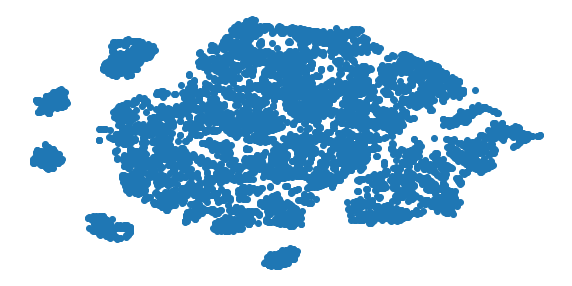

In [12]:
# Use dimensionality reduction to further separate clusters
time_start = time.time()
tsne = TSNE(n_components=2, verbose=2, perplexity=50, n_iter=500, n_jobs=8)
tsne_results = tsne.fit_transform(scaled)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

# Plot results
plt.figure(figsize=(10,5))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.axis('off')
plt.show()

In [13]:
tsne_score = best_dbscan_cluster(tsne_results)
tsne_score

{'eps': 4, 'min_samps': 1, 'silhouette_score': 0.07067479, 'clusters': 6}

In [ ]:
# Use Gaussian Mixtrue model for further exploratory clustering

# Function will rank best clustering parameters using adjusted_rand_score as the scoring metric
def best_gmm_cluster(scaled, clusters):
    
    # Initialize values
    covariance = ['full', 'tied', 'diag', 'spherical']
    clust_list = [clusters-1, clusters, clusters+1]
    best = 0
    score = {}
    
    # Loop through hyperparameters and save best scoring combinations
    for cov in covariance:
        for clu in clust_list:
            dbscan = GaussianMixture(n_components=clu, covariance_type=cov, max_iter=200)
            clusters = dbscan.fit_predict(scaled)
            sil_score = silhouette_score(scaled, clusters, metric='euclidean')
                
            if sil_score > best:
                best = sil_score
                score['covariance'] = cov
                score['silhouette_score'] = sil_score
                score['clusters'] = clusters
                score['weights'] = clusters.weights_
                
    return score